### Recursive Feature Elimination (RFE) with Random Forest

This analysis aims to evaluate the performance of a Random Forest classifier after applying Recursive Feature Elimination (RFE) to select the most relevant features from a dataset with 450 initial features. The key steps include:

1. **Standardization**: The features are standardized to have a mean of 0 and a standard deviation of 1.
2. **Feature Selection**: RFE is applied with varying numbers of selected features (e.g., 5, 10, 20, etc.), using Random Forest to rank feature importance.
3. **Classification**: A Random Forest classifier is trained on the selected features.
4. **Cross-Validation**: Performance metrics such as accuracy, precision, recall, F1 score, and specificity are calculated using 5-fold cross-validation.
5. **Results Comparison**: The impact of different numbers of selected features on model performance is explored to determine the optimal feature set.

This analysis helps identify the ideal number of features that balance model simplicity and performance.


### Cross-Validation Process with Recursive Feature Elimination (RFE)

1. **Training Set Split**: 
   - The data is split into a training set and a validation set according to the current fold.

2. **Feature Selection**:
   - RFE is applied to the training set only, selecting the specified number of features based on their importance as determined by the Random Forest classifier trained on that fold's training data.

3. **Model Training**:
   - The Random Forest classifier is then trained on the reduced set of features selected by RFE for that fold.

4. **Validation**:
   - The trained model is evaluated on the validation set of the current fold, and performance metrics are recorded.

This process is repeated for each of the `k` folds, and the performance metrics are averaged across all folds to ensure an unbiased evaluation.


## Recursive Feature Elimination (RFE) can be used with classification models that provide some way to rank features, typically through a coef_ attribute (for linear models) or feature_importances_ attribute (for tree-based models).

We can try it with **Random Forest** & **Decision Trees**. For computational reasons, we're only trying this with RF.

### RFE Results with Varying Number of Selected Features

(these results were taken from executing the same code on another machine)

| Number of Features | Accuracy | Precision | Recall (Sensitivity) | F1 Score | Specificity |
|--------------------|----------|-----------|----------------------|----------|-------------|
| **5**              | 0.7987   | 0.7942    | 0.8488               | 0.8102   | 0.7617      |
| **10**             | 0.8044   | 0.8282    | 0.8148               | 0.8082   | 0.8075      |
| **15**             | 0.8272   | 0.8377    | 0.8471               | 0.8329   | 0.8186      |
| **20**             | 0.8158   | 0.8406    | 0.8148               | 0.8179   | 0.8297      |
| **25**             | 0.8272   | 0.8328    | 0.8458               | 0.8331   | 0.8186      |
| **30**             | 0.8387   | 0.8428    | 0.8546               | 0.8432   | 0.8297      |


In [3]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Remove the 'ID' column
X = X.drop(columns=['ID'])

# Flatten the target vector
y = y.values.ravel()

# Define the number of splits for Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the Random Forest parameters
rf_params = {
    'bootstrap': True,
    'criterion': 'gini',
    'max_depth': 2,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 50,
    'random_state': 42
}

# Define the number of features to select with RFE
n_features_to_select = [10, 30, 60, 90, 150]  # Adapt based on the total number of available features

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=['H', 'P']).ravel()
    return tn / (tn + fp)

# Define the scorers for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='P'),
    'recall': make_scorer(recall_score, pos_label='P'),  # Also sensitivity
    'f1': make_scorer(f1_score, pos_label='P'),
    'specificity': make_scorer(specificity)
}

# Dictionary to save the results
results = {}

# Iterate over each number of selected features
for n_features in n_features_to_select:
    # Create a pipeline with StandardScaler, RFE, and RandomForestClassifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),                 # Standardize the data
        ('rfe', RFE(estimator=RandomForestClassifier(**rf_params), n_features_to_select=n_features)),  # Apply RFE
        ('classifier', RandomForestClassifier(**rf_params))  # Random Forest Classifier
    ])
    
    # Perform cross-validation and calculate the metrics
    cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring, return_train_score=False)
    
    # Store the average metrics
    results[n_features] = {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'f1': np.mean(cv_results['test_f1']),
        'specificity': np.mean(cv_results['test_specificity'])
    }

    # Print the results for the current number of selected features
    print(f"\nRFE with {n_features} selected features:")
    print(f"  Accuracy: {results[n_features]['accuracy']:.4f}")
    print(f"  Precision: {results[n_features]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {results[n_features]['recall']:.4f}")
    print(f"  F1 Score: {results[n_features]['f1']:.4f}")
    print(f"  Specificity: {results[n_features]['specificity']:.4f}")



RFE with 10 selected features:
  Accuracy: 0.8215
  Precision: 0.8327
  Recall (Sensitivity): 0.8378
  F1 Score: 0.8241
  Specificity: 0.8186

RFE with 30 selected features:
  Accuracy: 0.8158
  Precision: 0.8279
  Recall (Sensitivity): 0.8218
  F1 Score: 0.8176
  Specificity: 0.8186

RFE with 60 selected features:
  Accuracy: 0.8331
  Precision: 0.8370
  Recall (Sensitivity): 0.8435
  F1 Score: 0.8360
  Specificity: 0.8297

RFE with 90 selected features:
  Accuracy: 0.8267
  Precision: 0.8267
  Recall (Sensitivity): 0.8701
  F1 Score: 0.8368
  Specificity: 0.7964

RFE with 150 selected features:
  Accuracy: 0.8561
  Precision: 0.8597
  Recall (Sensitivity): 0.8688
  F1 Score: 0.8587
  Specificity: 0.8519


### Summary of these last results

| Number of Features | Accuracy | Precision | Recall (Sensitivity) | F1 Score | Specificity |
|--------------------|----------|-----------|----------------------|----------|-------------|
| **10**             | 0.8215   | 0.8327    | 0.8378               | 0.8241   | 0.8186      |
| **30**             | 0.8158   | 0.8279    | 0.8218               | 0.8176   | 0.8186      |
| **60**             | 0.8331   | 0.8370    | 0.8435               | 0.8360   | 0.8297      |
| **90**             | 0.8267   | 0.8267    | 0.8701               | 0.8368   | 0.7964      |
| **150**            | 0.8561   | 0.8597    | 0.8688               | 0.8587   | 0.8519      |


In [4]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Remove the 'ID' column
X = X.drop(columns=['ID'])

# Flatten the target vector
y = y.values.ravel()

# Define the number of splits for Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the Random Forest parameters
rf_params = {
    'bootstrap': True,
    'criterion': 'gini',
    'max_depth': 2,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 50,
    'random_state': 42
}

# Define the number of features to select with RFE
n_features_to_select = [180, 200, 230, 280]  # Adapt based on the total number of available features

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=['H', 'P']).ravel()
    return tn / (tn + fp)

# Define the scorers for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='P'),
    'recall': make_scorer(recall_score, pos_label='P'),  # Also sensitivity
    'f1': make_scorer(f1_score, pos_label='P'),
    'specificity': make_scorer(specificity)
}

# Dictionary to save the results
results = {}

# Iterate over each number of selected features
for n_features in n_features_to_select:
    # Create a pipeline with StandardScaler, RFE, and RandomForestClassifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),                 # Standardize the data
        ('rfe', RFE(estimator=RandomForestClassifier(**rf_params), n_features_to_select=n_features)),  # Apply RFE
        ('classifier', RandomForestClassifier(**rf_params))  # Random Forest Classifier
    ])
    
    # Perform cross-validation and calculate the metrics
    cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring, return_train_score=False)
    
    # Store the average metrics
    results[n_features] = {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'f1': np.mean(cv_results['test_f1']),
        'specificity': np.mean(cv_results['test_specificity'])
    }

    # Print the results for the current number of selected features
    print(f"\nRFE with {n_features} selected features:")
    print(f"  Accuracy: {results[n_features]['accuracy']:.4f}")
    print(f"  Precision: {results[n_features]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {results[n_features]['recall']:.4f}")
    print(f"  F1 Score: {results[n_features]['f1']:.4f}")
    print(f"  Specificity: {results[n_features]['specificity']:.4f}")



RFE with 180 selected features:
  Accuracy: 0.8679
  Precision: 0.8793
  Recall (Sensitivity): 0.8701
  F1 Score: 0.8695
  Specificity: 0.8742

RFE with 200 selected features:
  Accuracy: 0.8328
  Precision: 0.8253
  Recall (Sensitivity): 0.8806
  F1 Score: 0.8449
  Specificity: 0.7942

RFE with 230 selected features:
  Accuracy: 0.8444
  Precision: 0.8394
  Recall (Sensitivity): 0.8806
  F1 Score: 0.8523
  Specificity: 0.8186

RFE with 280 selected features:
  Accuracy: 0.8445
  Precision: 0.8383
  Recall (Sensitivity): 0.8801
  F1 Score: 0.8524
  Specificity: 0.8186


### Summary

| Number of Features | Accuracy | Precision | Recall (Sensitivity) | F1 Score | Specificity |
|--------------------|----------|-----------|----------------------|----------|-------------|
| **180**            | 0.8679   | 0.8793    | 0.8701               | 0.8695   | 0.8742      |
| **200**            | 0.8328   | 0.8253    | 0.8806               | 0.8449   | 0.7942      |
| **230**            | 0.8444   | 0.8394    | 0.8806               | 0.8523   | 0.8186      |
| **280**            | 0.8445   | 0.8383    | 0.8801               | 0.8524   | 0.8186      |


In [6]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Load the dataset
darwin = fetch_ucirepo(id=732)
X = darwin.data.features
y = darwin.data.targets

# Remove the 'ID' column
X = X.drop(columns=['ID'])

# Flatten the target vector
y = y.values.ravel()

# Define the number of splits for Cross-Validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the Random Forest parameters
rf_params = {
    'bootstrap': True,
    'criterion': 'gini',
    'max_depth': 2,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 50,
    'random_state': 42
}

# Define the number of features to select with RFE
n_features_to_select = [300, 350, 400, 450]  # Adapt based on the total number of available features

# Function to calculate specificity
def specificity(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=['H', 'P']).ravel()
    return tn / (tn + fp)

# Define the scorers for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, pos_label='P'),
    'recall': make_scorer(recall_score, pos_label='P'),  # Also sensitivity
    'f1': make_scorer(f1_score, pos_label='P'),
    'specificity': make_scorer(specificity)
}

# Dictionary to save the results
results = {}

# Iterate over each number of selected features
for n_features in n_features_to_select:
    # Create a pipeline with StandardScaler, RFE, and RandomForestClassifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),                 # Standardize the data
        ('rfe', RFE(estimator=RandomForestClassifier(**rf_params), n_features_to_select=n_features)),  # Apply RFE
        ('classifier', RandomForestClassifier(**rf_params))  # Random Forest Classifier
    ])
    
    # Perform cross-validation and calculate the metrics
    cv_results = cross_validate(pipeline, X, y, cv=kf, scoring=scoring, return_train_score=False)
    
    # Store the average metrics
    results[n_features] = {
        'accuracy': np.mean(cv_results['test_accuracy']),
        'precision': np.mean(cv_results['test_precision']),
        'recall': np.mean(cv_results['test_recall']),
        'f1': np.mean(cv_results['test_f1']),
        'specificity': np.mean(cv_results['test_specificity'])
    }

    # Print the results for the current number of selected features
    print(f"\nRFE with {n_features} selected features:")
    print(f"  Accuracy: {results[n_features]['accuracy']:.4f}")
    print(f"  Precision: {results[n_features]['precision']:.4f}")
    print(f"  Recall (Sensitivity): {results[n_features]['recall']:.4f}")
    print(f"  F1 Score: {results[n_features]['f1']:.4f}")
    print(f"  Specificity: {results[n_features]['specificity']:.4f}")


RFE with 300 selected features:
  Accuracy: 0.8440
  Precision: 0.8413
  Recall (Sensitivity): 0.8781
  F1 Score: 0.8527
  Specificity: 0.8186

RFE with 350 selected features:
  Accuracy: 0.8329
  Precision: 0.8427
  Recall (Sensitivity): 0.8471
  F1 Score: 0.8390
  Specificity: 0.8275

RFE with 400 selected features:
  Accuracy: 0.8674
  Precision: 0.8692
  Recall (Sensitivity): 0.8776
  F1 Score: 0.8703
  Specificity: 0.8631

RFE with 450 selected features:
  Accuracy: 0.8850
  Precision: 0.8729
  Recall (Sensitivity): 0.9149
  F1 Score: 0.8903
  Specificity: 0.8617


### Summary

| Number of Features | Accuracy | Precision | Recall (Sensitivity) | F1 Score | Specificity |
|--------------------|----------|-----------|----------------------|----------|-------------|
| **300**            | 0.8440   | 0.8413    | 0.8781               | 0.8527   | 0.8186      |
| **350**            | 0.8329   | 0.8427    | 0.8471               | 0.8390   | 0.8275      |
| **400**            | 0.8674   | 0.8692    | 0.8776               | 0.8703   | 0.8631      |
| **450**            | 0.8850   | 0.8729    | 0.9149               | 0.8903   | 0.8617      |

### OVERALL SUMMARY

| Number of Features | Accuracy | Precision | Recall (Sensitivity) | F1 Score | Specificity |
|--------------------|----------|-----------|----------------------|----------|-------------|
| **5**              | 0.7987   | 0.7942    | 0.8488               | 0.8102   | 0.7617      |
| **10**             | 0.8044   | 0.8282    | 0.8148               | 0.8082   | 0.8075      |
| **15**             | 0.8272   | 0.8377    | 0.8471               | 0.8329   | 0.8186      |
| **20**             | 0.8158   | 0.8406    | 0.8148               | 0.8179   | 0.8297      |
| **25**             | 0.8272   | 0.8328    | 0.8458               | 0.8331   | 0.8186      |
| **30**             | 0.8387   | 0.8428    | 0.8546               | 0.8432   | 0.8297      |
| **60**             | 0.8331   | 0.8370    | 0.8435               | 0.8360   | 0.8297      |
| **90**             | 0.8267   | 0.8267    | 0.8701               | 0.8368   | 0.7964      |
| **150**            | 0.8561   | 0.8597    | 0.8688               | 0.8587   | 0.8519      |
| **180**            | 0.8679   | 0.8793    | 0.8701               | 0.8695   | 0.8742      |
| **200**            | 0.8328   | 0.8253    | 0.8806               | 0.8449   | 0.7942      |
| **230**            | 0.8444   | 0.8394    | 0.8806               | 0.8523   | 0.8186      |
| **280**            | 0.8445   | 0.8383    | 0.8801               | 0.8524   | 0.8186      |
| **300**            | 0.8440   | 0.8413    | 0.8781               | 0.8527   | 0.8186      |
| **350**            | 0.8329   | 0.8427    | 0.8471               | 0.8390   | 0.8275      |
| **400**            | 0.8674   | 0.8692    | 0.8776               | 0.8703   | 0.8631      |
| **450**            | 0.8850   | 0.8729    | 0.9149               | 0.8903   | 0.8617      |

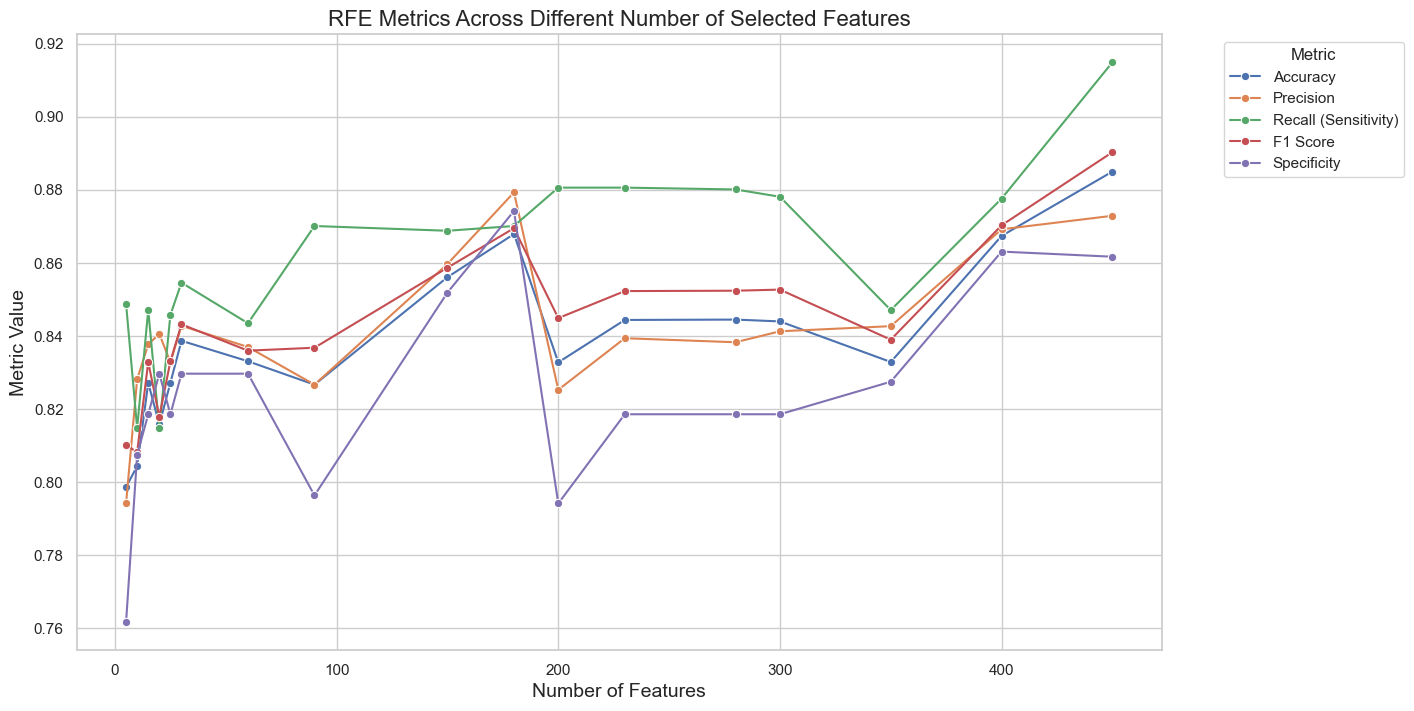

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    'Number of Features': [5, 10, 15, 20, 25, 30, 60, 90, 150, 180, 200, 230, 280, 300, 350, 400, 450],
    'Accuracy': [0.7987, 0.8044, 0.8272, 0.8158, 0.8272, 0.8387, 0.8331, 0.8267, 0.8561, 0.8679, 0.8328, 0.8444, 0.8445, 0.8440, 0.8329, 0.8674, 0.8850],
    'Precision': [0.7942, 0.8282, 0.8377, 0.8406, 0.8328, 0.8428, 0.8370, 0.8267, 0.8597, 0.8793, 0.8253, 0.8394, 0.8383, 0.8413, 0.8427, 0.8692, 0.8729],
    'Recall (Sensitivity)': [0.8488, 0.8148, 0.8471, 0.8148, 0.8458, 0.8546, 0.8435, 0.8701, 0.8688, 0.8701, 0.8806, 0.8806, 0.8801, 0.8781, 0.8471, 0.8776, 0.9149],
    'F1 Score': [0.8102, 0.8082, 0.8329, 0.8179, 0.8331, 0.8432, 0.8360, 0.8368, 0.8587, 0.8695, 0.8449, 0.8523, 0.8524, 0.8527, 0.8390, 0.8703, 0.8903],
    'Specificity': [0.7617, 0.8075, 0.8186, 0.8297, 0.8186, 0.8297, 0.8297, 0.7964, 0.8519, 0.8742, 0.7942, 0.8186, 0.8186, 0.8186, 0.8275, 0.8631, 0.8617]
}

# Create DataFrame
df = pd.DataFrame(data)

# Set the style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(14, 8))
sns.lineplot(x='Number of Features', y='value', hue='variable', 
             data=pd.melt(df, ['Number of Features']), marker='o')

# Titles and labels
plt.title('RFE Metrics Across Different Number of Selected Features', fontsize=16)
plt.xlabel('Number of Features', fontsize=14)
plt.ylabel('Metric Value', fontsize=14)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()


### There's a way to make this more efficient

Instead of restarting the RFE process for each value of n_features_to_select, you can leverage the fact that RFE eliminates features sequentially. Once RFE has identified the top n_features_to_select features, it can directly use those features without having to start over. This would imply to run RFE only once for each training set within the cross-validation folds, and can significantly reduce computation time.


### Previous Approach

For each value in `n_features_to_select`, the entire RFE process and cross-validation were run independently:

1. **For `n_features_to_select = 5`:**
   - Cross-Validation Fold 1:
     - RFE (starting from all features)
     - Train Model
     - Test Model
   - Cross-Validation Fold 2:
     - RFE (starting from all features)
     - Train Model
     - Test Model
   - ...
   - Cross-Validation Fold 5:
     - RFE (starting from all features)
     - Train Model
     - Test Model

2. **For `n_features_to_select = 10`:**
   - Cross-Validation Fold 1:
     - RFE (starting from all features)
     - Train Model
     - Test Model
   - Cross-Validation Fold 2:
     - RFE (starting from all features)
     - Train Model
     - Test Model
   - ...
   - Cross-Validation Fold 5:
     - RFE (starting from all features)
     - Train Model
     - Test Model

3. **Repeat for each value in `n_features_to_select`...**

This approach reruns RFE from scratch for each feature subset size, even though the initial ranking process (removing the least important features) is redundant for smaller subsets, leading to unnecessary computation.

---

### New, More Efficient Approach

In the new approach, RFE is run once per cross-validation fold to rank all features, and then subsets of the ranked features are used directly. Imagine having n_features_to_select = [150, 90, 5]:

1. **Cross-Validation Fold 1:**
   - **RFE (starting from all features, rank all features)**
     - Select Top 150 Features
       - Train Model
       - Test Model
     - Select Top 90 Features
       - Train Model
       - Test Model
     - Select Top 5 Features
       - Train Model
       - Test Model

2. **Cross-Validation Fold 2:**
   - **RFE (starting from all features, rank all features)**
     - Select Top 150 Features
       - Train Model
       - Test Model
     - Select Top 90 Features
       - Train Model
       - Test Model
     - Select Top 5 Features
       - Train Model
       - Test Model

3. **Repeat for each fold...**

This method ranks all features in one pass of RFE per fold (i.e. for each training-validation split in cross-validation), allowing to directly select subsets of different sizes without rerunning the entire RFE process. This avoids redundant calculations and significantly reduces computational time.

## A similar thing could be done with NMIFS